<a href="https://colab.research.google.com/github/saghar-trade/Time-series/blob/main/Mlairline_with_diffrencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
!pip install -U scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 69.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:


path = "/content/drive/MyDrive/air_passengers.csv"
df = pd.read_csv(path, index_col='Month', parse_dates=True)
print(df.head())


            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


In [6]:
df['LogPassengers'] = np.log(df['Passengers'])

df['logDiff'] = df['LogPassengers'].diff()
df = df.dropna().reset_index(drop=True)


In [7]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]


In [8]:
print(train.tail())
print(test.head())

     Passengers  LogPassengers   logDiff
126         559       6.326149  0.019874
127         463       6.137727 -0.188422
128         407       6.008813 -0.128914
129         362       5.891644 -0.117169
130         405       6.003887  0.112243
     Passengers  LogPassengers   logDiff
131         417       6.033086  0.029199
132         391       5.968708 -0.064379
133         419       6.037871  0.069163
134         461       6.133398  0.095527
135         472       6.156979  0.023581


In [9]:
# Make supervised dataset
# let's see if we can use T past values to predict the next value

series = df['logDiff'].to_numpy()[1:]

T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)


In [10]:
X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)



X.shape (132, 10) Y.shape (132,)


In [11]:
# تقسیم داده‌ها به train/test
Xtrain, Xtest = X[:-Ntest], X[-Ntest:]
Ytrain, Ytest = Y[:-Ntest], Y[-Ntest:]



In [12]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [13]:
print(lr.score(Xtrain, Ytrain))  # Train R^2
print(lr.score(Xtest, Ytest))    # Test R^2


0.6835786227300655
0.6486168306309639


In [14]:
Ypred = lr.predict(Xtest)
mape = mean_absolute_percentage_error(Ytest, Ypred)
r2 = r2_score(Ytest, Ypred)

 Boolean Index

In [15]:
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False  # first T values are not predictable


In [16]:
df.loc[:, 'ShiftLogPassengers'] = df['LogPassengers'].shift(1)



In [17]:
prev = df['ShiftLogPassengers']


In [18]:
# توجه: یکی کمتر از len(Ytrain)+T تا طول دقیقاً برابر شود
df.loc[df.index[T:T+len(Ytrain)], 'LR_1step_train'] = prev.iloc[T:T+len(Ytrain)].values + lr.predict(Xtrain)
df.loc[df.index[T+len(Ytrain):T+len(Ytrain)+len(Ytest)], 'LR_1step_test'] = prev.iloc[T+len(Ytrain):T+len(Ytrain)+len(Ytest)].values + lr.predict(Xtest)






In [19]:
# --- مقدار واقعی آخرین نقطه‌ی train (آخرین y واقعی قبل از تست)
last_train = train.iloc[-1]['LogPassengers']

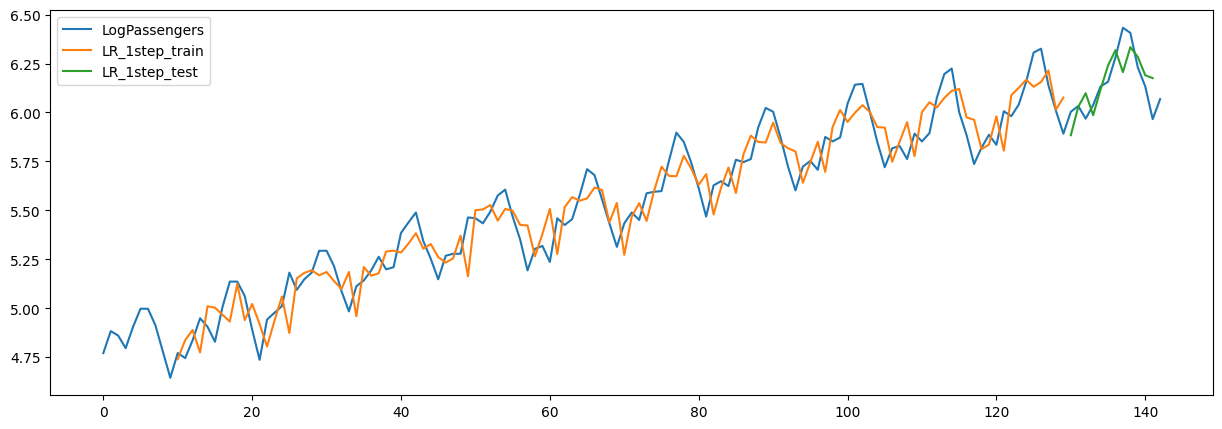

In [20]:
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5));


In [21]:

multistep_predictions = []

# شروع از اولین سطر تست (Xtest[0])
last_x = Xtest[0].copy()
last_y = last_train  # مقدار آخر واقعی قبل از تست

for i in range(len(Ytest)):
    # پیش‌بینی تفاضل بعدی (Δŷ_t)
    y_diff_pred = lr.predict(last_x.reshape(1, -1)).ravel()[0]

    # بازگردانی به مقدار اصلی (undifferencing)
    y_pred = last_y + y_diff_pred
    multistep_predictions.append(y_pred)


In [22]:
  # به‌روزرسانی ورودی برای مرحله بعد
last_x = np.roll(last_x, -1)
last_x[-1] = y_diff_pred
  # مقدار جدید واقعی برای مرحله‌ی بعد
last_y = y_pred

In [23]:
# برش دقیق بر اساس طول واقعی پیش‌بینی‌ها
start_idx = len(Ytrain) + T
end_idx = start_idx + len(multistep_predictions)

df.loc[df.index[start_idx:end_idx], 'LR_multistep'] = multistep_predictions


In [24]:
from sklearn.metrics import mean_absolute_percentage_error

Ytrue = df.loc[df.index[start_idx:end_idx], 'LogPassengers']
mape = mean_absolute_percentage_error(Ytrue, multistep_predictions)
print("Multi-step MAPE:", mape)


Multi-step MAPE: 0.025833438715127624


In [25]:
df.loc[df.index[start_idx:end_idx], 'LR_multistep'] = multistep_predictions


## **multi-step**

In [26]:
Tx = T        # تعداد lag ها (تعداد ورودی)
Ty = Ntest    # تعداد خروجی‌ها (افق پیش‌بینی)
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]               # ورودی: Tx مقدار قبلی
    X.append(x)

    y = series[t+Tx:t+Tx+Ty]         # خروجی: Ty مقدار بعدی
    Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y)


In [27]:
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)

X.shape: (121, 10)
Y.shape: (121, 12)


In [28]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m,  Ytest_m  = X[-1:], Y[-1:]


In [29]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)


0.8148625167678626

In [30]:
from sklearn.metrics import r2_score

r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())


0.7662178545730982

In [31]:
df.loc[test_idx, 'LR_multioutput'] = last_train + np.cumsum(lr.predict(Xtest_m).flatten())


In [32]:
# 0) ایندکس تست و آخرین مقدار واقعیِ درست
test_idx  = df.index[-Ntest:]                                     # دقیقا 12 تا آخر
last_train = df.loc[df.index[-Ntest-1], 'LogPassengers']          # آخرین y واقعی قبل از تست

# 1) پیش‌بینی multi-step را از صفر و روی Δy بساز (بدون دخالت df)
multistep_diff = []
last_x = Xtest[0].copy()
for _ in range(len(test_idx)):
    d_hat = lr.predict(last_x.reshape(1,-1)).ravel()[0]           # Δŷ_t
    multistep_diff.append(float(d_hat))
    last_x = np.roll(last_x, -1)
    last_x[-1] = d_hat                                            # ورودی بعدی = Δŷ

# 2) تبدیل Δŷ به ŷ واقعی — فقط یک بار cumsum
multistep_real = last_train + np.cumsum(multistep_diff)

# 3) هر گونه ستون قبلیِ آلوده را پاک کن و مقدار درست را بنشان
if 'LR_multistep' in df.columns:
    df.drop(columns=['LR_multistep'], inplace=True)

df.loc[test_idx, 'LR_multistep'] = multistep_real

# 4) یک چک کوچک برای معقول‌بودن مقیاس
print('last_train=', last_train, '  min/max multistep_real=', float(np.min(multistep_real)), float(np.max(multistep_real)))


last_train= 6.003887067106539   min/max multistep_real= 5.996136435103222 6.421372272811806


In [33]:
print('shapes:', len(test_idx), len(multistep_diff), len(multistep_real))
print(df[['LogPassengers']].iloc[-Ntest-3:-Ntest+1])   # 3 تا قبلِ تست و آخرین train
print(df[['LogPassengers','LR_multistep']].iloc[-Ntest:].head())


shapes: 12 12 12
     LogPassengers
128       6.008813
129       5.891644
130       6.003887
131       6.033086
     LogPassengers  LR_multistep
131       6.033086      5.996136
132       5.968708      6.029387
133       6.037871      6.095236
134       6.133398      6.065233
135       6.156979      6.175924


In [36]:
from sklearn.metrics import mean_absolute_percentage_error


test_log_pass = df.iloc[-Ntest:]['LogPassengers']

mape1 = mean_absolute_percentage_error(
    test_log_pass,
    df.loc[test_idx, 'LR_multistep']
)
print("multi-step MAPE:", mape1)

# محاسبه‌ی خطای MAPE برای مدل چندخروجی
mape2 = mean_absolute_percentage_error(
    test_log_pass,
    df.loc[test_idx, 'LR_multioutput']
)
print("multi-output MAPE:", mape2)


multi-step MAPE: 6.297042908011169
multi-output MAPE: 0.005294635505300776
